# ALGORITHMIC MACHINE LEARNING REGRESSION PROGRAM

This is a tiny part of a huge algorithm for trading in stock market. The global functioning is to download/update stock prices from some finance api, of a long list of tickers (the most valuables companies in terms of estimated market cap) and understand them through correlations, traditional tech analysis, ML and NLP from news and social net, in order to make decisions to improve investments.

The fragment that I am sharing in this case is an algorithm that automatically makes the following operations:

* Feature selection using **kbest**, and **correlations** with different pearson coefficients.
* Scaling transformations (or not): **StandardScaler, MinMaxScaler, Normalizer and no scaling**.
* ML Regression models instatiation (**Linear, Ridge, BayesianRidge, Lasso, ElasticNet, SVR, SGD, DesicionTree, RandomForest, Polynomic and Kneighbors**).
* Hyper parameters optimization using **GridSearch - Cross Validation**.
* **Train-Test proportion** optimization.
* **ML Regression models training and scoring**.
* Report results.

### 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px
import plotly.offline as py
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, Normalizer

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, Lasso, SGDRegressor, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["font.family"] = "consolas"
plt.rcParams['figure.facecolor'] = '#AFC4D4'

### 2. Data loaded from previous workflows

In [2]:
ticks_strategy = ['AAPL', 'BMW.DE', 'BTC-USD', 'ETH-USD', 'GOOGL', 'MSFT', 'NVDA', 'SHEL.L', 'TSLA']

In [3]:
data = pd.read_parquet("export/data.gzip")

In [4]:
# Calculation
ticks = pd.read_csv("tickers/1150ticks.txt",header = None).values.flatten()
ohlcv_cols = data.columns.get_level_values(1).unique()[:-2].values
data2y_ret = data.pct_change().dropna(how="all").fillna(0).loc["2020":,(ticks,ohlcv_cols)]
data2y_ret.replace([np.inf,-np.inf],0,inplace=True)

# Import
# data2y_ret = pd.read_parquet("export/data2y_ret.gzip")

In [5]:
# Calculation
# matcorr_data2y_ret = np.round(data2y_ret.corr("pearson").astype(float),3)

# Import
matcorr_data2y_ret = pd.read_parquet("export/matcorr_data2y_ret.gzip")

In [6]:
from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-RenderedImage.jp-mod-trusted.jp-OutputArea-output {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### 3. Algortihmic Regression Model

#### 3.1 Functions

In [7]:
## MODEL SELECTION WITH KBEST. FUNCTION THAT RETURNS DATA WITH, IN THIS CASE, 100 BEST FEATURES TO USE AS INPUT IN MODELS
def kbest(df, target_tic_stock, k=100):
    """
    Input:
        * DataFrame from where to get train data
        * target tic stock (ex. ("AAPL", "Close"))
        * k; number of top features to select (default = 100)
        * RETURNS: featureScores and y
    """
    X = df.iloc[:,np.where(df.columns != target_tic_stock)[0]]
    y = df[target_tic_stock].values

    bestfeatures = SelectKBest(score_func=f_regression, k=k)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
   
    return featureScores, y

## FUNCTION THAT RETURNS A DICTIONARY (results_grid) WITH BEST HYPER PARAMETER COMBINATION PER MODEL AND TICKER
def reg_hyper_params(model, target_tic, X, y, datain, tscv,ts):
    global results_grid

    if model == 'bayridge_reg':
        estimator = BayesianRidge()
        alpha_init = [0.01, 0.1, 1, 10]
        lambda_init = [0.01, 0.1, 1, 10]
        param_grid = dict(alpha_init=alpha_init, lambda_init=lambda_init)        
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)

    elif model == 'ridge_reg':
        estimator = Ridge()
        alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        param_grid = dict(alpha=alpha)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)
    
    elif model == 'lasso_reg':
        estimator = Lasso()
        alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        param_grid = dict(alpha = alpha)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)
    
    elif model == 'elastic_reg':
        estimator = ElasticNet()
        alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
        l1_ratio = [np.round(0.2*y,1) for y in range(0,6)]
        param_grid = dict(alpha = alpha, l1_ratio = l1_ratio)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)
    
    elif model == 'svm_reg':
        estimator = SVR()
        kernel = ['linear', 'poly', 'rbf', 'sigmoid']
        C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
        degree = [2,3]
        param_grid = dict(kernel = kernel, C = C, degree = degree)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)
    
    elif model == 'sdg_reg':
        estimator = SGDRegressor()
        alpha = [0.001, 0.01, 0.1, 1, 10, 100]
        l1_ratio = [np.round(0.2*y,1) for y in range(0,6)]
        learning_rate = ["constant", "optimal", "invscaling", "adaptive"]
        eta0 = [0.001, 0.01, 0.1, 1, 10]
        param_grid = dict(alpha = alpha, l1_ratio = l1_ratio, learning_rate = learning_rate, eta0 = eta0)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)
    
    elif model == 'tree_reg':
        estimator = DecisionTreeRegressor()
        max_depth = [y for y in range(1,16)]
        param_grid = dict(max_depth = max_depth)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)
    
    elif model == 'ranforest_reg':
        estimator = RandomForestRegressor(n_jobs = -1)
        max_depth = [y for y in range(1,16)]
        param_grid = dict(max_depth = max_depth)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)

    elif model == 'poly_reg':
        estimator = make_pipeline(PolynomialFeatures(), LinearRegression(n_jobs = -1))
        param_grid = {'polynomialfeatures__degree': range(2,4)}
                      # 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
        grid = GridSearchCV(estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_
        return grid.fit(X,y)
    
    elif model == 'knei_reg':
        estimator = KNeighborsRegressor(n_jobs = -1)
        n_neighbors = [y for y in range(1,20)]
        param_grid = dict(n_neighbors = n_neighbors)
        grid = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring = "r2", n_jobs = -1, cv = tscv, return_train_score = True)
        results_grid[(target_tic,model,datain,ts)] = grid.fit(X,y).best_params_        
        return grid.fit(X,y)
    
    else:
        print("No regression model selected")

## FUNCTION THAT TEST EVERY MODEL WITH DIFFERENT TRAIN TEST PROPORTIONS
def test_size_opt_reg(X, y, target_tic, model, datain, n_features):
    global results_reg_df
    
    test_size_porc = [np.round(0.05*x,2) for x in range(1,8)]
    for ts in test_size_porc:
        n_splits = int(np.trunc(X.shape[0]/int(X.shape[0]*ts)))
        test_size = int(X.shape[0]*ts)
        tscv = TimeSeriesSplit(n_splits = n_splits, gap = 0, test_size = test_size-1)
        
        if model == "lin_reg":
            estimator = LinearRegression()
            ind = X.shape[0]-int(X.shape[0]*ts)
            X_train, X_test = X[:ind,:], X[ind:,:]
            y_train, y_test = y[:ind], y[ind:]
            estimator.fit(X_train,y_train)
            results_reg_df.loc[(target_tic,model,datain, n_features, ts, n_splits),:] = (np.round(r2_score(y_train,estimator.predict(X_train)),2),
                                                                           0,
                                                                           0,
                                                                           np.round(r2_score(y_test,estimator.predict(X_test)),2),
                                                                           0,
                                                                           0)             
        else:    
            grid_fit = reg_hyper_params(model, target_tic, X, y, datain, tscv,ts)
            results_reg_df.loc[(target_tic,model,datain, n_features, ts, n_splits),:] = (np.round(grid_fit.cv_results_[f'split{n_splits-1}_train_score'][grid_fit.best_index_],2),
                                                                           np.round(grid_fit.cv_results_['mean_train_score'][grid_fit.best_index_],2),
                                                                           np.round(grid_fit.cv_results_['std_train_score'][grid_fit.best_index_],2),
                                                                           np.round(grid_fit.cv_results_[f'split{n_splits-1}_test_score'][grid_fit.best_index_],2),
                                                                           np.round(grid_fit.cv_results_['mean_test_score'][grid_fit.best_index_],2),
                                                                           np.round(grid_fit.cv_results_['std_test_score'][grid_fit.best_index_],2))                                                                    
    return results_reg_df

#### 3.2 Header

In [8]:
results_grid = dict() # Grid Search results

# Cross Validation results and Timeseries split optimization results
results_reg_df = pd.DataFrame(index = pd.MultiIndex.from_arrays([["ticker"],["model"],["datain"],["n_features"],["test_size_prop"], ["n_splits"]]), 
                    columns = pd.MultiIndex.from_product([["train","test"], ["score", "mean_scorecv","std_scorecv"]])).iloc[1:,:]
results_reg_df.index.names = ["ticker","model","datain","n_features", "test_size_prop", "n_splits"]

In [9]:
## DATA
df = data2y_ret
datain = "rets"

## REGRESSION MODELS TO CONSIDER
# Possible models to use: 
# ['lin_reg', 'ridge_reg', 'lasso_reg', 'elastic_reg', 'svm_reg', 'sdg_reg', 'bayridge_reg', 'tree_reg', 'ranforest_reg', 'poly_reg', 'knei_reg']
models = np.array(['lin_reg', 'ridge_reg', 'lasso_reg', 'elastic_reg', 'bayridge_reg', 'tree_reg'])

## MODEL SELECTION
corr_selection = True
ncoef = np.array([np.round((x+0.05),2) for x in np.arange(0.5,0.85,0.05)])
matcorr = matcorr_data2y_ret

kbest_selection = True
nkbest = 4

scaling = True
scalers = [StandardScaler(), MinMaxScaler(), Normalizer(),"nosc"]

## ML ALGORITHM
regression = True
scoring = ["r2"]

#### 3.3 Import Algortihmic Regression Model Results to Parquet
As the main program could take a while to process, is important to export results to import them in future and avoid running it again.

In [10]:
results_reg_df = pd.read_parquet("export/ML_algo_reg_res/results_reg_df.gzip")
best_models = pd.read_parquet("export/ML_algo_reg_res/best_models.gzip")
best_models1 = pd.read_parquet("export/ML_algo_reg_res/best_models1.gzip") 
to_improve = pd.read_parquet("export/ML_algo_reg_res/to_improve.gzip")
results_grid2 = pd.read_parquet("export/ML_algo_reg_res/results_grid2.gzip")
results_grid = results_grid2.to_dict(orient="index")

#### 3.4 Main program

In [ ]:
now1 = datetime.now()

for target_tic in ticks_strategy:
    target_tic_stock = (target_tic,"Close")
    
    for model in models:
        if corr_selection:
            flag_kbest = True
            for coef in ncoef:
                df_corr_coef = matcorr[target_tic][(matcorr[target_tic] > coef) | (matcorr[target_tic] < -coef)]["Close"].dropna(how="all")
                ticks_corr = df_corr_coef.index.unique()
                ticks_corr = np.delete(ticks_corr,np.where(ticks_corr == target_tic_stock))
                if ticks_corr.size > 5:
                    flag_kbest = False # IF THE TICKER GETS IN AT LEAST 1 TIME, WILL NOT GET INSIDE KBEST
                    X = df[ticks_corr].values
                    y = df[target_tic_stock].values            
                    
                    if datain.find("_corr") == -1:
                        datain = datain+"_corr"+f"{coef}"
                    else:
                        datain = datain[:datain.find("_corr")]+"_corr"+f"{coef}"
                    n_features = X.shape[1]
                    ## DATA SCALING    
                    if scaling:
                        for scaler in scalers:
                            if scaler != "nosc":
                                X_sc = scaler.fit_transform(X)                              
                                sc_var = "_sc"+str(scaler)[:4]
                                if datain.find("_sc") == -1 and datain.find("_nosc") == -1:
                                    datain = datain+sc_var
                                elif datain.find("_sc") == -1 and datain.find("_nosc") != -1:
                                    datain = datain[:datain.find("_nosc")]+sc_var
                                else:
                                    datain = datain[:datain.find("_sc")]+sc_var
    
                                ## HYPER-PARAMETERS OPTIMIZATION. GRID SEARCH. SCORES RESULTS DF
                                if regression:
                                    n1 = datetime.now()
                                    results_reg_df = test_size_opt_reg(X_sc, y, target_tic, model, datain, n_features)
                                    n2 = datetime.now()
                                    print(target_tic,model,coef,scaler,"regression",f"{np.round((n2-n1).seconds / 60,2)} minutes")

                            else:
                                sc_var = "_nosc"
                                if datain.find("_nosc") == -1 and datain.find("_sc") == -1:
                                    datain = datain+sc_var       
                                elif datain.find("_sc") != -1 and datain.find("_nosc") == -1:
                                    datain = datain[:datain.find("_sc")]+sc_var      
                                else:
                                    datain = datain[:datain.find("_nosc")]+sc_var
                                    
                                ## HYPER-PARAMETERS OPTIMIZATION. GRID SEARCH. SCORES RESULTS DF
                                if regression:
                                    n1 = datetime.now()
                                    results_reg_df = test_size_opt_reg(X, y, target_tic, model, datain, n_features)
                                    n2 = datetime.now()
                                    print(target_tic,model,coef,scaler,"regression",f"{np.round((n2-n1).seconds / 60,2)} minutes")

                    else:
                        ## HYPER-PARAMETERS OPTIMIZATION. GRID SEARCH. SCORES RESULTS DF
                        if regression:
                            n1 = datetime.now()
                            results_reg_df = test_size_opt_reg(X, y, target_tic, model, datain, n_features)
                            n2 = datetime.now()
                            print(target_tic,model,coef,scaler,"regression",f"{np.round((n2-n1).seconds / 60,2)} minutes")
            
            if flag_kbest:
                featureScores, y = kbest(df, target_tic_stock, 100)
                for n in np.array([np.int(featureScores.shape[0]*.01)*i for i in range(1,nkbest)]):
                    X = df[featureScores.nlargest(n,'Score').Specs.values].values
                    n_features = X.shape[1]
                    
                    if datain.find("_kbest") == -1 and datain.find("_corr") == -1:
                        datain = datain+"_kbest"+f"{X.shape[1]}"
                    elif datain.find("_corr") != -1:
                        datain = datain[:datain.find("_corr")]+"_kbest"+f"{X.shape[1]}"
                    else:
                        datain = datain[:datain.find("_kbest")]+"_kbest"+f"{X.shape[1]}"
                        
                    if scaling:
                        for scaler in scalers:
                            if scaler != "nosc":
                                X_sc = scaler.fit_transform(X)                              
                                sc_var = "_sc"+str(scaler)[:4]
                                if datain.find("_sc") == -1 and datain.find("_nosc") == -1:
                                    datain = datain+sc_var
                                elif datain.find("_sc") == -1 and datain.find("_nosc") != -1:
                                    datain = datain[:datain.find("_nosc")]+sc_var
                                else:
                                    datain = datain[:datain.find("_sc")]+sc_var
    
                                ## HYPER-PARAMETERS OPTIMIZATION. GRID SEARCH. SCORES RESULTS DF
                                if regression:
                                    n1 = datetime.now()
                                    results_reg_df = test_size_opt_reg(X_sc, y, target_tic, model, datain, n_features)
                                    n2 = datetime.now()
                                    print(target_tic,model,"kbest",scaler,"regression",f"{np.round((n2-n1).seconds / 60,2)} minutes")
                    
                            else:
                                sc_var = "_nosc"
                                if datain.find("_nosc") == -1 and datain.find("_sc") == -1:
                                    datain = datain+sc_var       
                                elif datain.find("_sc") != -1 and datain.find("_nosc") == -1:
                                    datain = datain[:datain.find("_sc")]+sc_var      
                                else:
                                    datain = datain[:datain.find("_nosc")]+sc_var
                                    
                                ## HYPER-PARAMETERS OPTIMIZATION. GRID SEARCH. SCORES RESULTS DF
                                if regression:
                                    n1 = datetime.now()
                                    results_reg_df = test_size_opt_reg(X, y, target_tic, model, datain, n_features)
                                    n2 = datetime.now()
                                    print(target_tic,model,"kbest",scaler,"regression",f"{np.round((n2-n1).seconds / 60,2)} minutes")                                    

                    else:
                        ## HYPER-PARAMETERS OPTIMIZATION. GRID SEARCH. SCORES RESULTS DF
                        if regression:
                            n1 = datetime.now()
                            results_reg_df = test_size_opt_reg(X, y, target_tic, model, datain, n_features)
                            n2 = datetime.now()
                            print(target_tic,model,"kbest","regression",f"{np.round((n2-n1).seconds / 60,2)} minutes")
        elif kbest_selection:
            featureScores, y = kbest(df, target_tic_stock, 100)    
            for n in np.array([np.int(featureScores.shape[0]*.01)*i for i in range(1,nkbest)]):
                n1 = datetime.now()
                X = df[featureScores.nlargest(n,'Score').Specs.values].values
                n_features = X.shape[1]

                if datain.find("_kbest") == -1 and datain.find("_corr") == -1:
                    datain = datain+"_kbest"+f"{X.shape[1]}"
                elif datain.find("_corr") != -1:
                    datain = datain[:datain.find("_corr")]+"_kbest"+f"{X.shape[1]}"
                else:
                    datain = datain[:datain.find("_kbest")]+"_kbest"+f"{X.shape[1]}"
            
                ## DATA SCALING    
                if scaling:
                    for scaler in scalers:
                        if scaler != "nosc":
                            X_sc = scaler.fit_transform(X)                              
                            sc_var = "_sc"+str(scaler)[:4]
                            if datain.find("_sc") == -1 and datain.find("_nosc") == -1:
                                datain = datain+sc_var
                            elif datain.find("_sc") == -1 and datain.find("_nosc") != -1:
                                datain = datain[:datain.find("_nosc")]+sc_var
                            else:
                                datain = datain[:datain.find("_sc")]+sc_var
                            ## HYPER-PARAMETERS OPTIMIZATION. GRID SEARCH. SCORES RESULTS DF
                            if regression:
                                n1 = datetime.now()
                                results_reg_df = test_size_opt_reg(X_sc, y, target_tic, model, datain, n_features)
                                n2 = datetime.now()
                                print(target_tic,model,"kbest_selection",scaler,"regression",f"{np.round((n2-n1).seconds / 60,2)} minutes")

                        else:
                            if datain.find("_nosc") == -1 and datain.find("_sc") == -1:
                                datain = datain+"_nosc"        
                            elif datain.find("_sc") != -1 and datain.find("_nosc") == -1:
                                datain = datain[:datain.find("_sc")]+"_nosc"       
                            else:
                                datain = datain[:datain.find("_nosc")]+"_nosc"
                            
                            ## HYPER-PARAMETERS OPTIMIZATION. GRID SEARCH. SCORES RESULTS DF
                            if regression:
                                n1 = datetime.now()
                                results_reg_df = test_size_opt_reg(X, y, target_tic, model, datain, n_features)
                                n2 = datetime.now()
                                print(target_tic,model,"kbest_selection",scaler,"regression",f"{np.round((n2-n1).seconds / 60,2)} minutes")

                else:
                    if datain.find("_nosc") == -1 and datain.find("_sc") == -1:
                        datain = datain+"_nosc"        
                    elif datain.find("_sc") != -1 and datain.find("_nosc") == -1:
                        datain = datain[:datain.find("_sc")]+"_nosc"       
                    else:
                        datain = datain[:datain.find("_nosc")]+"_nosc"
    
                    ## HYPER-PARAMETERS OPTIMIZATION. GRID SEARCH. SCORES RESULTS DF
                    if regression:
                        n1 = datetime.now()
                        results_reg_df = test_size_opt_reg(X, y, target_tic, model, datain, n_features)
                        n2 = datetime.now()
                        print(target_tic,model,"kbest_selection",scaler,"regression",f"{np.round((n2-n1).seconds / 60,2)} minutes")                        
        else:
            print("Set selection method")

best_models1 = results_reg_df.copy().astype(float)
best_models1.columns = results_reg_df.columns.map('_'.join)
best_models1 = best_models1.loc[best_models1.groupby(["ticker"])['test_score'].idxmax().values,:]
to_improve = best_models1[best_models1["test_score"] < 0.86]
best_models = best_models1[best_models1.index.isin(to_improve.index) == False]
best_models.columns = pd.MultiIndex.from_product([["train","test"], ["score", "mean_scorecv","std_scorecv"]])

del sc_var

now2 = datetime.now()
delta = now2 - now1
print(f"ML Optimization Done! - Process time: {delta.seconds} seconds ({np.round(delta.seconds / 60,2)} minutes)")

In [11]:
print("""
Resulted DataFrame:

""")
best_models1


Resulted DataFrame:




,,,,,,train_score,train_mean_scorecv,train_std_scorecv,test_score,test_mean_scorecv,test_std_scorecv
ticker,model,datain,n_features,test_size_prop,n_splits,,,,,,
AAPL,elastic_reg,rets_corr0.55_scStan,133,0.10,10,0.92,0.95,0.03,0.96,0.87,0.06
BMW.DE,ridge_reg,rets_corr0.6_scMinM,88,0.10,10,0.92,0.93,0.05,0.84,0.82,0.04
BTC-USD,elastic_reg,rets_corr0.65_scMinM,10,0.05,20,0.75,0.78,0.06,0.88,0.70,0.14
ETH-USD,lin_reg,rets_corr0.7_scStan,10,0.05,20,0.84,0.00,0.00,0.93,0.00,0.00
GOOGL,lin_reg,rets_corr0.55_scStan,134,0.05,20,0.99,0.00,0.00,1.00,0.00,0.00
MSFT,elastic_reg,rets_corr0.55_scStan,175,0.05,20,0.94,0.96,0.02,0.96,0.87,0.05
NVDA,ridge_reg,rets_corr0.55_scStan,108,0.25,4,0.93,0.96,0.02,0.94,0.82,0.09
SHEL.L,elastic_reg,rets_corr0.55_scStan,155,0.10,10,0.94,0.97,0.02,0.84,0.84,0.07
TSLA,elastic_reg,rets_kbest134_scStan,134,0.25,4,0.84,0.91,0.06,0.79,0.60,0.13


In [12]:
print("Models that are not that good and can be improved using other algorithms: ")
to_improve

Models that are not that good and can be improved using other algorithms: 


,,,,,,train_score,train_mean_scorecv,train_std_scorecv,test_score,test_mean_scorecv,test_std_scorecv
ticker,model,datain,n_features,test_size_prop,n_splits,,,,,,
BMW.DE,ridge_reg,rets_corr0.6_scMinM,88,0.10,10,0.92,0.93,0.05,0.84,0.82,0.04
SHEL.L,elastic_reg,rets_corr0.55_scStan,155,0.10,10,0.94,0.97,0.02,0.84,0.84,0.07
TSLA,elastic_reg,rets_kbest134_scStan,134,0.25,4,0.84,0.91,0.06,0.79,0.60,0.13


In [13]:
best_models

train  \
                                                                            score   
ticker  model       datain               n_features test_size_prop n_splits         
AAPL    elastic_reg rets_corr0.55_scStan 133        0.10           10        0.92   
BTC-USD elastic_reg rets_corr0.65_scMinM 10         0.05           20        0.75   
ETH-USD lin_reg     rets_corr0.7_scStan  10         0.05           20        0.84   
GOOGL   lin_reg     rets_corr0.55_scStan 134        0.05           20        0.99   
MSFT    elastic_reg rets_corr0.55_scStan 175        0.05           20        0.94   
NVDA    ridge_reg   rets_corr0.55_scStan 108        0.25           4         0.93   

                                                                                          \
                                                                            mean_scorecv   
ticker  model       datain               n_features test_size_prop n_splits                
AAPL    elastic_reg rets_corr0.55_scStan 133        0.10           10               0.95   
BTC-USD elastic_reg rets_corr0.65_scMinM 10         0.05           20               0.78   
ETH-USD lin_reg     rets_corr0.7_scStan  10         0.05           20               0.00   
GOOGL   lin_reg     rets_corr0.55_scStan 134        0.05           20               0.00   
MSFT    elastic_reg rets_corr0.55_scStan 175        0.05           20               0.96   
NVDA    ridge_reg   rets_corr0.55_scStan 108        0.25           4                0.96   

                                                                                         \
                                                                            std_scorecv   
ticker  model       datain               n_features test_size_prop n_splits               
AAPL    elastic_reg rets_corr0.55_scStan 133        0.10           10              0.03   
BTC-USD elastic_reg rets_corr0.65_scMinM 10         0.05           20              0.06   
ETH-USD lin_reg     rets_corr0.7_scStan  10         0.05           20              0.00   
GOOGL   lin_reg     rets_corr0.55_scStan 134        0.05           20              0.00   
MSFT    elastic_reg rets_corr0.55_scStan 175        0.05           20              0.02   
NVDA    ridge_reg   rets_corr0.55_scStan 108        0.25           4               0.02   

                                                                             test  \
                                                                            score   
ticker  model       datain               n_features test_size_prop n_splits         
AAPL    elastic_reg rets_corr0.55_scStan 133        0.10           10        0.96   
BTC-USD elastic_reg rets_corr0.65_scMinM 10         0.05           20        0.88   
ETH-USD lin_reg     rets_corr0.7_scStan  10         0.05           20        0.93   
GOOGL   lin_reg     rets_corr0.55_scStan 134        0.05           20        1.00   
MSFT    elastic_reg rets_corr0.55_scStan 175        0.05           20        0.96   
NVDA    ridge_reg   rets_corr0.55_scStan 108        0.25           4         0.94   

                                                                                          \
                                                                            mean_scorecv   
ticker  model       datain               n_features test_size_prop n_splits                
AAPL    elastic_reg rets_corr0.55_scStan 133        0.10           10               0.87   
BTC-USD elastic_reg rets_corr0.65_scMinM 10         0.05           20               0.70   
ETH-USD lin_reg     rets_corr0.7_scStan  10         0.05           20               0.00   
GOOGL   lin_reg     rets_corr0.55_scStan 134        0.05           20               0.00   
MSFT    elastic_reg rets_corr0.55_scStan 175        0.05           20               0.87   
NVDA    ridge_reg   rets_corr0.55_scStan 108        0.25           4                0.82   

                                                                  

#### 3.5 Export Algortihmic Regression Model Results to Parquet

In [ ]:
results_grid2 = pd.DataFrame.from_dict(results_grid,orient="index")
results_reg_df.to_parquet("export/ML_algo_reg_res/results_reg_df.gzip", compression = "gzip")
best_models.to_parquet("export/ML_algo_reg_res/best_models.gzip", compression = "gzip")
best_models1.to_parquet("export/ML_algo_reg_res/best_models1.gzip", compression = "gzip") 
to_improve.to_parquet("export/ML_algo_reg_res/to_improve.gzip", compression = "gzip")
results_grid2.to_parquet("export/ML_algo_reg_res/results_grid2.gzip", compression = "gzip")

### 4. Algorithmic Regression Models Results

In [14]:
results_reg_df.head()

train  \
                                                                       score   
ticker model   datain               n_features test_size_prop n_splits         
AAPL   lin_reg rets_corr0.55_scStan 133        0.05           20        0.95   
                                               0.10           10        0.95   
                                               0.15           6         0.95   
                                               0.20           5         0.95   
                                               0.25           4         0.95   

                                                                                     \
                                                                       mean_scorecv   
ticker model   datain               n_features test_size_prop n_splits                
AAPL   lin_reg rets_corr0.55_scStan 133        0.05           20                0.0   
                                               0.10           10                0.0   
                                               0.15           6                 0.0   
                                               0.20           5                 0.0   
                                               0.25           4                 0.0   

                                                                                    \
                                                                       std_scorecv   
ticker model   datain               n_features test_size_prop n_splits               
AAPL   lin_reg rets_corr0.55_scStan 133        0.05           20               0.0   
                                               0.10           10               0.0   
                                               0.15           6                0.0   
                                               0.20           5                0.0   
                                               0.25           4                0.0   

                                                                        test  \
                                                                       score   
ticker model   datain               n_features test_size_prop n_splits         
AAPL   lin_reg rets_corr0.55_scStan 133        0.05           20        0.93   
                                               0.10           10        0.93   
                                               0.15           6         0.92   
                                               0.20           5         0.92   
                                               0.25           4         0.92   

                                                                                     \
                                                                       mean_scorecv   
ticker model   datain               n_features test_size_prop n_splits                
AAPL   lin_reg rets_corr0.55_scStan 133        0.05           20                0.0   
                                               0.10           10                0.0   
                                               0.15           6                 0.0   
                                               0.20           5                 0.0   
                                               0.25           4                 0.0   

                                                                                    
                                                                       std_scorecv  
ticker model   datain               n_features test_size_prop n_splits              
AAPL   lin_reg rets_corr0.55_scStan 133        0.05           20               0.0  
                                               0.10           10               0.0  
                                               0.15           6                0.0  
                                               0.20           5                0.0  
                                               0.25           4                0.0

In [15]:
res_reg_analysis = results_reg_df.astype(float)
res_reg_analysis.columns = res_reg_analysis.columns.map('_'.join)
res_reg_analysis = res_reg_analysis.reset_index()

## Filter of coef higher than 0.8 to filter Kbest runs
res_reg_analysis["coef"] = np.where(res_reg_analysis.datain.str.extract('([0-9][.]*[0-9]*)').astype(float)[0] > 0.8,
         0, res_reg_analysis.datain.str.extract('([0-9][.]*[0-9]*)')[0]).astype(float)

res_reg_analysis["scaling"] = res_reg_analysis.datain.str.split("_", expand = True)[2]
res_reg_analysis = res_reg_analysis.iloc[:,[0,1,-2,-1,3,4,6,7,8,9,10,11]]

In [16]:
res_reg_analysis_grp = pd.DataFrame(res_reg_analysis.groupby(["ticker","model","coef","n_features","scaling","test_size_prop"])["train_score","test_score"].mean())
res_reg_analysis_grp = res_reg_analysis_grp.reset_index()
res_reg_analysis_grp.coef = res_reg_analysis_grp.coef.astype(float)

In [17]:
res_reg_analysis_grp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6720 entries, 0 to 6719
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ticker          6720 non-null   object 
 1   model           6720 non-null   object 
 2   coef            6720 non-null   float64
 3   n_features      6720 non-null   int64  
 4   scaling         6720 non-null   object 
 5   test_size_prop  6720 non-null   float64
 6   train_score     6720 non-null   float64
 7   test_score      6720 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 420.1+ KB


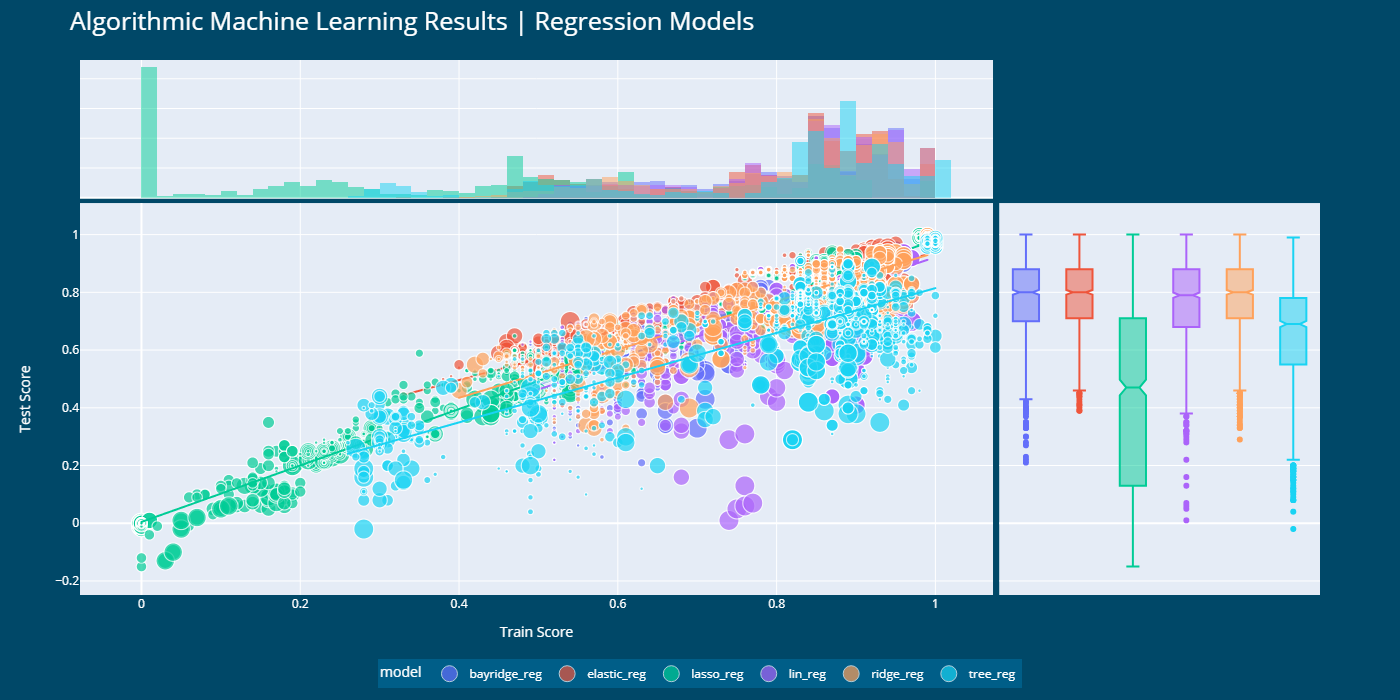

In [18]:
fig = px.scatter(res_reg_analysis_grp, x = "train_score", y = "test_score", marginal_x = "histogram", marginal_y = "box", 
           color = "model", size = "n_features", trendline = "ols", height = 700, width = 1400)

fig.update_layout(title = "Algorithmic Machine Learning Results | Regression Models", title_font = dict(size = 25, color = "white"),
                  paper_bgcolor = '#004868',
                  xaxis = dict(title = "Train Score", titlefont = dict(color = "white"), tickfont = dict(color = "white")),
                  yaxis = dict(title = "Test Score", titlefont = dict(color = "white"), tickfont = dict(color = "white")),                  
                  legend = dict(orientation = "h", x=0.5, y=-0.12, xanchor = "auto", itemsizing = "trace", 
                                bgcolor = "#005E88", itemdoubleclick = "toggleothers",
                                font = dict(color = "white")),
                 )

# py.plot(fig, filename = "RegML_algo_results", auto_open = False)
# fig.show()
fig.show("png")

#### 4.1 Prelimiar conclusions

* **Bayridge, Elastic, Linear and Ridge** have similar results and are suitable to use for this dataset.

* In this case lasso regression has worst results and a wider range in its scores.

* Bayridge and linear regression have a some trend regarding number of features and scores. The less we use them to train models, the worst they predict. But considering its whole sample, these results have low frequency.

### 5. Best Models Prediction
Unpacking results table to instantiate non trained estimator as pipeline from best models per ticker.<br>
Results gotten from next piece of code are:
* *estimator* dictionary, which keys are the models and its values are pipelines with best settings.
* *X_train, X_test* dictionary, which keys are the tickers and its values are feature arrays with best split sizes.
* *y_train, y_test* dictionary, which keys are the tickers and its values are target arrays with best split sizes.
* *sc* dictionary, which keys are the tickers and its values are the best scalers methods.

In [19]:
X = dict()
y = dict()
sc = dict()
X_train = dict()
X_test = dict()
y_train = dict()
y_test = dict()
estimator = dict()

#### 5.1 Main function that returns pipeline with best setting regarding selected model

In [20]:
def reg_estimator(model, target_tic, X, y, datain, results_grid,ts,sc):

    if model == 'lin_reg':
        if sc != "nosc":
            return make_pipeline(sc, LinearRegression())
        else:
            return LinearRegression()
        
    elif model == 'bayridge_reg':
        if sc != "nosc":
            return make_pipeline(sc, BayesianRidge())
        else:
            return BayesianRidge()        

    elif model == 'ridge_reg':
        if sc != "nosc":
            return make_pipeline(sc, Ridge(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"]))
        else:
            return Ridge(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"])
    
    elif model == 'lasso_reg':
        if sc != "nosc":
            return make_pipeline(sc, Lasso(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"]))
        else:
            return Lasso(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"])
    
    elif model == 'elastic_reg':
        if sc != "nosc":
            return make_pipeline(sc, ElasticNet(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"], l1_ratio = results_grid[(target_tic,model,datain,ts)]["l1_ratio"]))
        else:
            return ElasticNet(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"], l1_ratio = results_grid[(target_tic,model,datain,ts)]["l1_ratio"])       
    
    elif model == 'svm_reg':
        if sc != "nosc":
            return make_pipeline(sc, SVR(kernel = results_grid[(target_tic,model,datain,ts)]["kernel"], 
                      degree = results_grid[(target_tic,model,datain,ts)]["degree"],
                     C = results_grid[(target_tic,model,datain,ts)]["C"]))
        else:
            return SVR(kernel = results_grid[(target_tic,model,datain,ts)]["kernel"], 
                      degree = results_grid[(target_tic,model,datain,ts)]["degree"],
                     C = results_grid[(target_tic,model,datain,ts)]["C"])
    
    elif model == 'sdg_reg':
        if sc != "nosc":
            return make_pipeline(sc, SGDRegressor(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"], l1_ratio = results_grid[(target_tic,model,datain,ts)]["l1_ratio"],
                              learning_rate = results_grid[(target_tic,model,datain,ts)]["learning_rate"], eta0 = results_grid[(target_tic,model,datain,ts)]["eta0"]))
        else:       
            return SGDRegressor(alpha = results_grid[(target_tic,model,datain,ts)]["alpha"], l1_ratio = results_grid[(target_tic,model,datain,ts)]["l1_ratio"],
                              learning_rate = results_grid[(target_tic,model,datain,ts)]["learning_rate"], eta0 = results_grid[(target_tic,model,datain,ts)]["eta0"])
    
    elif model == 'tree_reg':
        if sc != "nosc":
            return make_pipeline(sc, DecisionTreeRegressor(max_depth = results_grid[(target_tic,model,datain,ts)]["max_depth"]))
        else:
            return DecisionTreeRegressor(max_depth = results_grid[(target_tic,model,datain,ts)]["max_depth"])
    
    elif model == 'ranforest_reg':
        if sc != "nosc":
            return make_pipeline(sc, RandomForestRegressor(max_depth = results_grid[(target_tic,model,datain,ts)]["max_depth"], n_jobs = -1))
        else:
            return RandomForestRegressor(max_depth = results_grid[(target_tic,model,datain,ts)]["max_depth"], n_jobs = -1)
    
    elif model == 'poly_reg':
        if sc != "nosc":
            return make_pipeline(sc, PolynomialFeatures(degree = results_grid[(target_tic,model,datain,ts)]["polynomialfeatures__degree"]), LinearRegression())
        else:
            return make_pipeline(PolynomialFeatures(degree = results_grid[(target_tic,model,datain,ts)]["polynomialfeatures__degree"]), LinearRegression())
    
    elif model == 'knei_reg':
        if sc != "nosc":
            return make_pipeline(sc, KNeighborsRegressor(n_neighbors = results_grid[(target_tic,model,datain,ts)]["n_neighbors"], n_jobs = -1))
        else:
            return KNeighborsRegressor(n_neighbors = results_grid[(target_tic,model,datain,ts)]["n_neighbors"], n_jobs = -1)
    
    else:
        print("No regression model selected")

#### 5.2 Iteration trought best results to create *estimator dictionary*

In [21]:
for n in range(best_models1.index.size):
    target_tic = best_models1.index[n][0]
    model = best_models1.index[n][1]
    datain = best_models1.index[n][2]
    test_size_prop = float(best_models1.index[n][4])
    target_tic_stock = (target_tic,"Close")
    flag_nosc = True
    
    ## DATA
    if datain.split("_")[0] == "rets":
        df = data2y_ret
    else:
        print("There is a problem with initial df")
        
    ## MODEL SELECTION
    if datain.split("_")[1].find("corr") != -1: # CORRELATION SELECTION
        coef = float(datain.split("_")[1][datain.split("_")[1].find("0"):])
        df_corr_coef = matcorr[target_tic][(matcorr[target_tic] > coef) | (matcorr[target_tic] < -coef)]["Close"].dropna(how="all")
        ticks_corr = df_corr_coef.index.unique()
        ticks_corr = np.delete(ticks_corr,np.where(ticks_corr == target_tic_stock))
        X[target_tic] = df[ticks_corr].values
        y[target_tic] = df[target_tic_stock].values

    elif datain.split("_")[1].find("kbest") != -1: # KBEST SELECTION
        n = int(datain.split("_")[1][datain.split("_")[1].find("t")+1:])
        X[target_tic] = df.iloc[:,np.where(df.columns != target_tic_stock)[0]]  # Correlated Features truncated S steps in the end
        y[target_tic] = df[target_tic_stock].values # Target shifted S steps
        
        bestfeatures = SelectKBest(score_func=f_regression, k=n)
        fit = bestfeatures.fit(X[target_tic],y[target_tic])
        dfscores = pd.DataFrame(fit.scores_)
        dfcolumns = pd.DataFrame(X[target_tic].columns)
        featureScores = pd.concat([dfcolumns,dfscores],axis=1)
        featureScores.columns = ['Specs','Score']
        X[target_tic] = df[featureScores.nlargest(n,'Score').Specs.values].values
    else:
        print("There is a problem with model selection")
    
    ## DATA SCALING 
    for i in range(len(scalers)):
        if str(scalers[i]).find(datain.split("_")[2][2:]) == 0:
            flag_nosc = False
            sc[target_tic] = scalers[i]
    if flag_nosc:
        sc[target_tic] = "nosc"
        print(f"{target_tic} not scaled")
    
    ## ESTIMATOR INSTANTIATION
    if model.split("_")[1] == "reg":
        try:
            ## SPLITS DEFINITION
            best_ind = X[target_tic].shape[0]-int(X[target_tic].shape[0]*test_size_prop)
            X_train[target_tic], X_test[target_tic] = X[target_tic][:best_ind,:], X[target_tic][best_ind:,:]
            y_train[target_tic], y_test[target_tic] = y[target_tic][:best_ind], y[target_tic][best_ind:]
            
            ## BEST MODEL INSTANTIATION
            estimator[target_tic] = reg_estimator(model, target_tic,
                                                  X_train[target_tic], y_train[target_tic],
                                                  datain, results_grid, test_size_prop, sc[target_tic])
        except:
            print(f"There is a problem modelling {target_tic} ")

print("Done!")

Done!


#### 5.3 Comparison between table and dictionary gotten to validate code

In [22]:
estimator

{'AAPL': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('elasticnet', ElasticNet(alpha=0.001, l1_ratio=0.2))]),
 'BMW.DE': Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('ridge', Ridge(alpha=0.1))]),
 'BTC-USD': Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('elasticnet', ElasticNet(alpha=0.001, l1_ratio=0.0))]),
 'ETH-USD': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('linearregression', LinearRegression())]),
 'GOOGL': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('linearregression', LinearRegression())]),
 'MSFT': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('elasticnet', ElasticNet(alpha=0.001, l1_ratio=0.2))]),
 'NVDA': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('ridge', Ridge(alpha=10.0))]),
 'SHEL.L': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('elasticnet', ElasticNet(alpha=0.0001, l1_ratio=1.0

In [23]:
best_models1

,,,,,,train_score,train_mean_scorecv,train_std_scorecv,test_score,test_mean_scorecv,test_std_scorecv
ticker,model,datain,n_features,test_size_prop,n_splits,,,,,,
AAPL,elastic_reg,rets_corr0.55_scStan,133,0.10,10,0.92,0.95,0.03,0.96,0.87,0.06
BMW.DE,ridge_reg,rets_corr0.6_scMinM,88,0.10,10,0.92,0.93,0.05,0.84,0.82,0.04
BTC-USD,elastic_reg,rets_corr0.65_scMinM,10,0.05,20,0.75,0.78,0.06,0.88,0.70,0.14
ETH-USD,lin_reg,rets_corr0.7_scStan,10,0.05,20,0.84,0.00,0.00,0.93,0.00,0.00
GOOGL,lin_reg,rets_corr0.55_scStan,134,0.05,20,0.99,0.00,0.00,1.00,0.00,0.00
MSFT,elastic_reg,rets_corr0.55_scStan,175,0.05,20,0.94,0.96,0.02,0.96,0.87,0.05
NVDA,ridge_reg,rets_corr0.55_scStan,108,0.25,4,0.93,0.96,0.02,0.94,0.82,0.09
SHEL.L,elastic_reg,rets_corr0.55_scStan,155,0.10,10,0.94,0.97,0.02,0.84,0.84,0.07
TSLA,elastic_reg,rets_kbest134_scStan,134,0.25,4,0.84,0.91,0.06,0.79,0.60,0.13


#### 5.4 Chart: Train-Test distributions validation
It is a good practice and quality control to compare train and test distributions, as it gets with the split proportion chosen, in order to validate that we are working with data that behaves similarly and the consequent models are more representative. <br>
In this excercise we are using as example a random number of features used to train AAPL stock, to plot them and compare these subsets in a multiple plot chart. <br>
**As we can see, every sample has distributions with almost the same shape, so they are good to feed ML models**

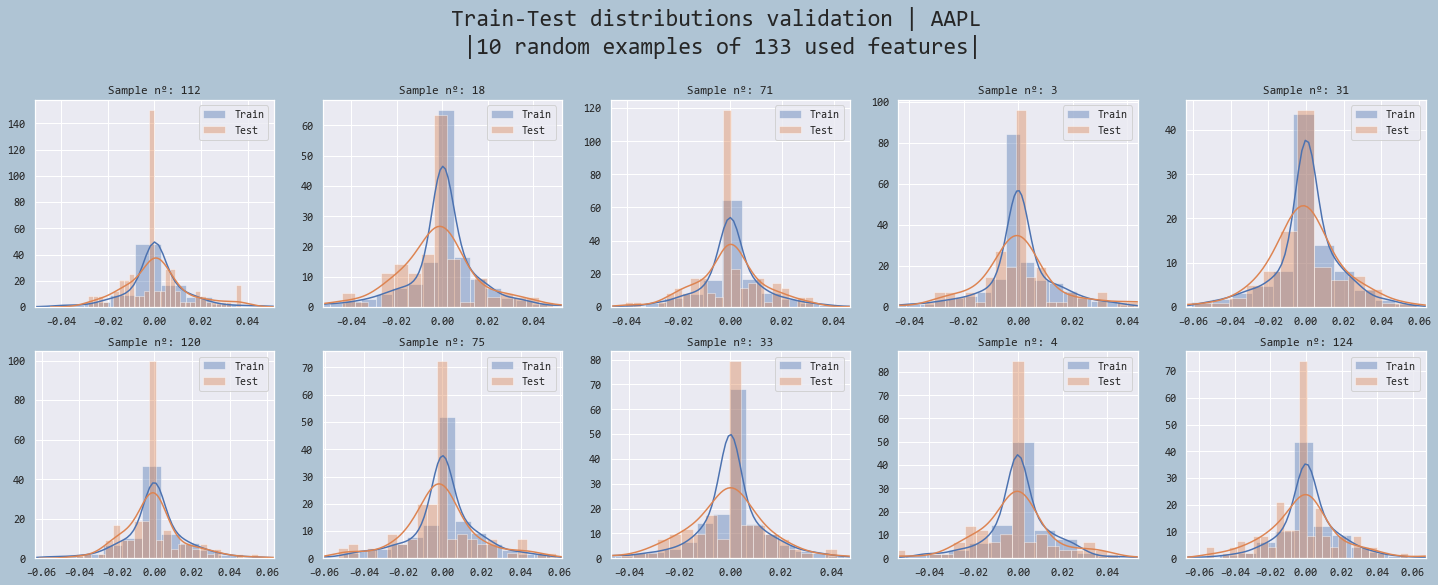

In [24]:
target_tic = "AAPL"
size = 10
rows = 2
cols = int(size/2)
samples = np.random.choice(X_train[target_tic].shape[1], size = size)
i = 0
fig, axes = plt.subplots(rows,cols,figsize = (20,8))
plt.suptitle(f"Train-Test distributions validation | {target_tic}\n |10 random examples of {X[target_tic].shape[1]} used features|", fontsize = 23, y = 1.01)
for row in range(rows):
    for col in range(cols):
        ax = axes[row][col]
        sns.distplot(X_train[target_tic][:,samples[i]], ax=ax, bins = 30, label = "Train")
        sns.distplot(X_test[target_tic][:,samples[i]], ax=ax, bins = 30, label = "Test")
        ax.legend()
        ax.set_xlim(-np.std(X_train[target_tic][:,samples[i]])*3, np.std(X_train[target_tic][:,samples[i]])*3)
        ax.set_title(f"Sample nº: {samples[i]}")
        ax.set_ylabel(None)
        i +=1
plt.tight_layout()
plt.show()

#### 5.2 Chart: Learning Curves MSE - R2
Here we can see how each model converge to a better solution (minor error between prediction and real data), as more data is used to feed it, tending to the optimal split proportion gotten before.

In [25]:
def plot_learning_curves(target_tic, X, y, ax1, ax2, ylim11 = None, ylim12 = None, ylim21 = None, ylim22 = None, mult_annoty = 1):
    """
    Input:
        * model
        * X
        * y
        * train test split size (default = 0.3)
        * ax, if you want to plot it in a combined plot (default = "")
        * ylims (default = None)
        * ylims (default = None)
    """
    model = estimator[target_tic]
    test_size = best_models1.loc[(best_models1.index.get_level_values(0) == target_tic)].index.get_level_values(4)[0]

    X_train, X_test, y_train, y_test = train_test_split(X[target_tic], y[target_tic], test_size = test_size, random_state = 42)
    train_errors, test_errors = [], []
    train_scores, test_scores = [], []
    
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
            
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))
        
        train_scores.append(r2_score(y_train[:m], y_train_predict))
        test_scores.append(r2_score(y_test, y_test_predict))
    
    ax1.set_title(f"{target_tic} | mean squared error", font = "consolas", fontsize = 20, pad = 15)
    ax1.plot(np.sqrt(train_errors), "r-", linewidth=2, label="Train mse")
    ax1.plot(np.sqrt(test_errors), "b-", linewidth=3, label="Test mse")
    ax1.set_ylim(ylim11,ylim12)
    ax1.set_ylabel("MSE", fontsize = 12)
    ax1.annotate(f"{np.round(np.sqrt(test_errors[-1]),3)}", [len(test_errors),np.sqrt(test_errors[-1])], 
                 xytext=(len(test_errors)*.92,np.sqrt(test_errors[-1]*mult_annoty)), 
                 fontsize = 16, color = "g", fontweight = "bold",
                 bbox = dict(facecolor = "white", edgecolor = "darkgreen", linewidth = 0.5),
                 arrowprops=dict(facecolor='gray', edgecolor='gray', arrowstyle = "<-"))
    
    ax2.set_title(f"{target_tic} | r2 score", font = "consolas", fontsize = 20, pad = 15)
    ax2.plot(train_scores, c = "coral", linewidth=2, label="Train r2 score")
    ax2.plot(test_scores, c = "skyblue", linewidth=3, label="Test r2 score")
    ax2.set_ylim(ylim21,ylim22)
    ax2.set_ylabel("r2 score", fontsize = 12)
    ax2.annotate(f"{np.round(test_scores[-1],2)}", [len(test_scores),test_scores[-1]], 
                 xytext=(len(test_scores)*.95,test_scores[-1]*.8),
                 fontsize = 16, color = "g", fontweight = "bold",
                 bbox = dict(facecolor = "white", edgecolor = "darkgreen", linewidth = 0.5),
                 arrowprops=dict(facecolor='gray', edgecolor='gray', arrowstyle = "<-"))

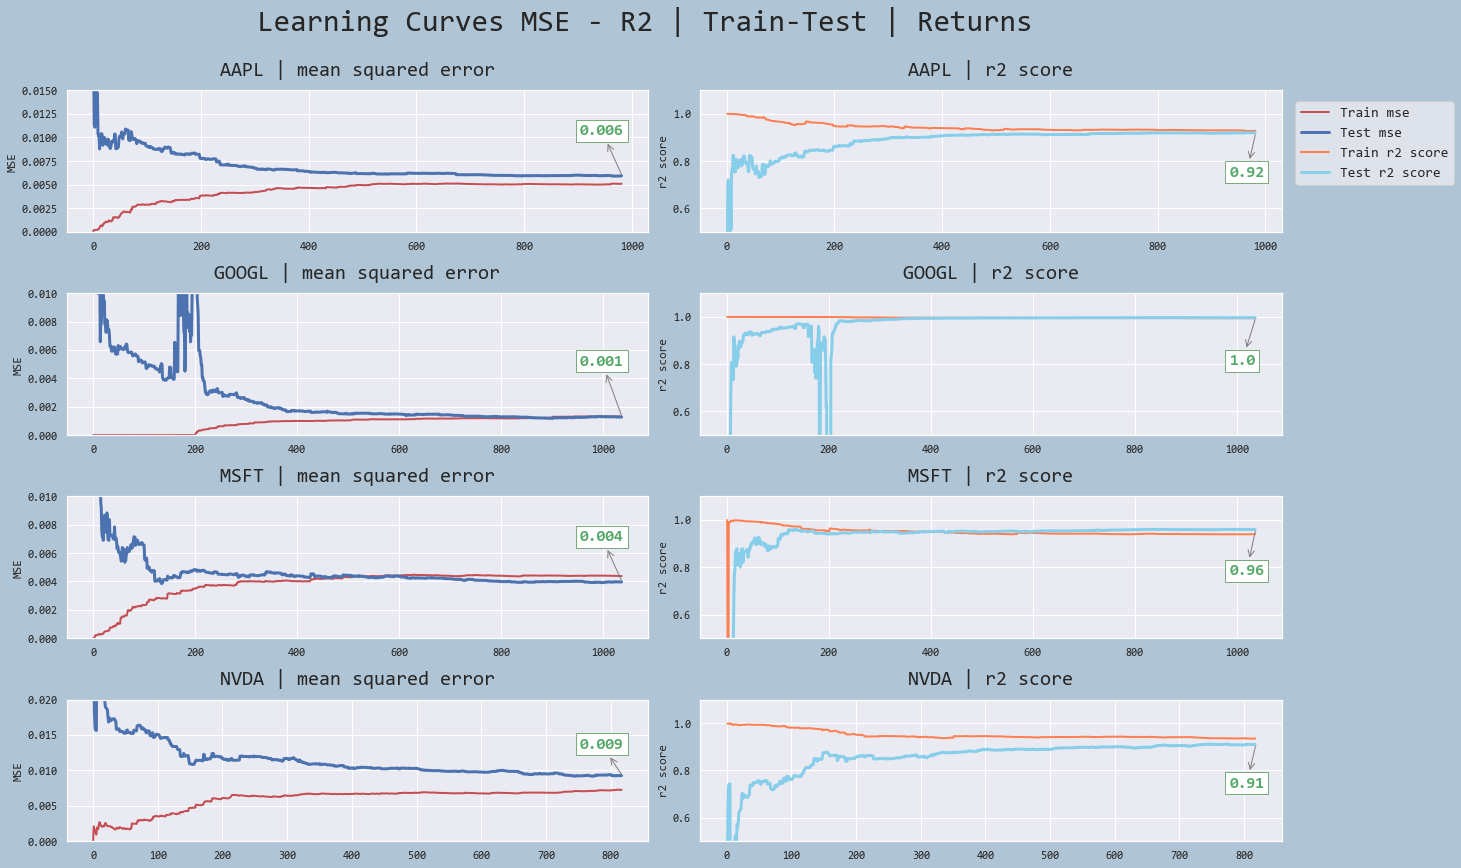

In [26]:
fig,ax = plt.subplots(figsize = (18,12))
fig.suptitle("Learning Curves MSE - R2 | Train-Test | Returns", fontsize = 30, y = 1.001)

ax1 = plt.subplot(4,2,1)
ax2 = plt.subplot(4,2,2)
ax3 = plt.subplot(4,2,3)
ax4 = plt.subplot(4,2,4)
ax5 = plt.subplot(4,2,5)
ax6 = plt.subplot(4,2,6)
ax7 = plt.subplot(4,2,7)
ax8 = plt.subplot(4,2,8)

plot_learning_curves("AAPL", X, y, ax1, ax2, ylim11 = 0, ylim12 = 0.015, ylim21 = 0.5, ylim22 = 1.1, mult_annoty = 3
                    )
plot_learning_curves("GOOGL", X, y, ax3, ax4, ylim11 = 0, ylim12 = 0.01, ylim21 = 0.5, ylim22 = 1.1, mult_annoty = 15)
plot_learning_curves("MSFT", X, y, ax5, ax6, ylim11 = 0, ylim12 = 0.01, ylim21 = 0.5, ylim22 = 1.1, mult_annoty = 3)
plot_learning_curves("NVDA", X, y, ax7, ax8, ylim11 = 0, ylim12 = 0.02, ylim21 = 0.5, ylim22 = 1.1, mult_annoty = 2)

lines = []
labels = []
for ax in fig.axes[:2]:
    line, label = ax.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)

fig.legend(lines, labels, fontsize = 14, bbox_to_anchor = [1.13,0.9])
fig.tight_layout()
plt.show()

#### 5.3 Chart: Regression Machine Learning models predictions
Finally we can plot the model predicted results and compare them with the real data, for every test period.

In [27]:
def pred_df(target_tic):
    """
    1. Returns for selected ticker a "test" dataframe with the following features:
        * Close Price for test range's time (closePrice_testRange)
        * Close Returns for test range's time (closeRets_testRange)
        * Cummulated Close Returns for test range's time (closeRetsCum_testRange)
        * Predicted Cummulated Close Returns for test range's time (cumRets_prediction)
        
    2. Returns for selected ticker a "train" dataframe with the following features:        
        * Close Price for train range's time (closePrice_trainRange)
        * Close Returns for train range's time (closeRets_trainRange)
        * Cummulated Close Returns for train range's time (closeRetsCum_trainRange)
    
    3. Tickers used as features to feed the models: ticks_corr
    """
    datain = best_models1.loc[best_models1.index.get_level_values(0) == target_tic,:].index[0][2]
    coef = float(datain.split("_")[1][datain.split("_")[1].find("0"):])
    df_corr_coef = matcorr[target_tic][(matcorr[target_tic] > coef) | (matcorr[target_tic] < -coef)]["Close"].dropna(how="all")
    ticks_corr = df_corr_coef.index.unique()
    ticks_corr = np.delete(ticks_corr,np.where(ticks_corr == target_tic_stock))
    
    test_size_ind = X_test[target_tic].shape[0]
    closePrice_testRange = data[target_tic]["Close"][-test_size_ind:]
    closeRets_testRange = data2y_ret[target_tic]["Close"][-test_size_ind:]
    closeRetsCum_testRange = closeRets_testRange.cumsum()
    
    train_size_ind = X_train[target_tic].shape[0]    
    closePrice_trainRange = data[target_tic]["Close"][-train_size_ind:-test_size_ind]
    closeRets_trainRange = data2y_ret[target_tic]["Close"][-train_size_ind:-test_size_ind]
    closeRetsCum_trainRange = closeRets_trainRange.cumsum()
    
    rets_prediction = estimator[target_tic].fit(X_train[target_tic], y_train[target_tic]).predict(X_test[target_tic])
    cumRets_prediction = rets_prediction.cumsum()
    df_xpred = pd.concat([closePrice_testRange, closeRets_testRange, closeRetsCum_testRange, pd.Series(cumRets_prediction, index = closePrice_testRange.index), pd.Series(rets_prediction, index = closePrice_testRange.index)], axis=1)
    df_xpred.columns = ["closePrice_testRange","closeRets_testRange","closeRetsCum_testRange","cumRets_prediction", "rets_prediction"]
    
    df_trainData = pd.concat([closePrice_trainRange, closeRets_trainRange, closeRetsCum_trainRange], axis=1)
    df_trainData.columns = ["closePrice_trainRange", "closeRets_trainRange", "closeRetsCum_trainRange"]
    
    return df_xpred, df_trainData, ticks_corr

def ax_plot(target_tic, ax, plot_features = True):
    """
    Plot same chart of different ticker in different axes.
    Args:
        * target_tic (str): ticker to plot
        * ax (str): axes number to be plotted
        * plot_features (Boolean): flag to plot features used to train
    """
    ax.set_title(f"{target_tic} | Test Score: {np.round(r2_score(y_test[target_tic], pred_df(target_tic)[0].iloc[:,-1]),2)}", font = "consolas", fontsize = 20, pad = 15)
    first_ind = -100
    ax.plot(pred_df(target_tic)[1].iloc[first_ind:,2], "--k", label = "Train Cum Returns")

    last_train_value = pred_df(target_tic)[1].iloc[-1,2]
    ax.plot(last_train_value + pred_df(target_tic)[0].iloc[:,2], linestyle = "dashed", c = "orange",  label = "Test Cum Returns")
    ax.plot(last_train_value + pred_df(target_tic)[0].iloc[:,3], "og", markersize = 5, alpha = 0.5, label = "Predicted Cum Returns (test)")
    
    if plot_features:
        feat_range = first_ind - pred_df(target_tic)[0].iloc[:,2].shape[0]
        try:
            ax.plot(data2y_ret.loc[:,pred_df(target_tic)[2]].cumsum().iloc[feat_range:,:], "gray", alpha = 0.05, label = "Training Features")
        except:
            pass
    
    trainTestRetsCum = pd.concat([pred_df(target_tic)[1].iloc[first_ind:,2], (pred_df(target_tic)[1].iloc[-1,2] + pred_df(target_tic)[0].iloc[:,2])], axis = 0)
    ax.set_ylim(trainTestRetsCum.min()*0.99, trainTestRetsCum.max()*1.01)
    ax.set_xlabel("Date")
    ax.set_ylabel("Cummulated Returns")

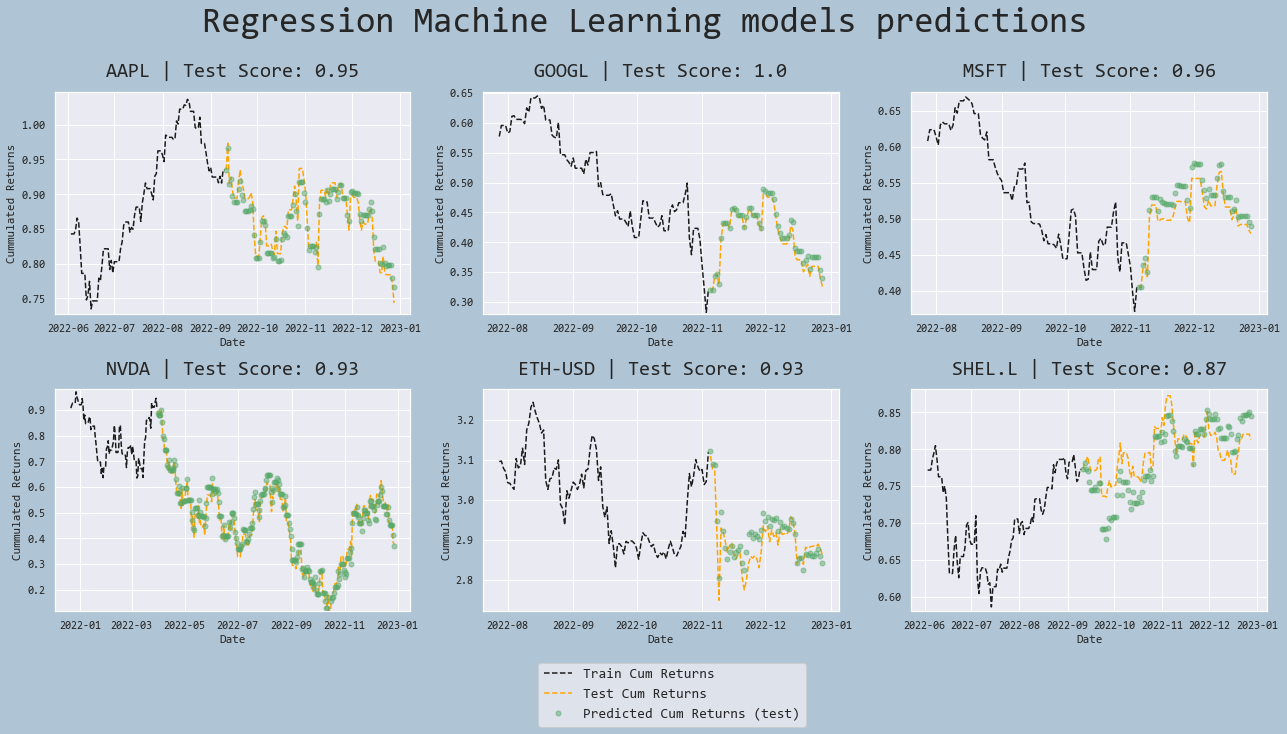

In [28]:
fig,ax = plt.subplots(figsize = (18,9))
fig.suptitle("Regression Machine Learning models predictions", fontsize = 35, y = 1.001)
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)

ax_plot("AAPL", ax1, plot_features = False)
ax_plot("GOOGL", ax2, plot_features = False)
ax_plot("MSFT", ax3, plot_features = False)
ax_plot("NVDA", ax4, plot_features = False)
ax_plot("ETH-USD", ax5, plot_features = False)
ax_plot("SHEL.L", ax6, plot_features = False)

lines = []
labels = []
for ax in fig.axes[:1]:
    line, label = ax.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)

fig.legend(lines, labels, fontsize = 14, bbox_to_anchor = [0.63,-0.000001])
fig.tight_layout()
plt.show()

### 6. Conclusions

* Even though we can infer in advance which models to use regarding the nature of data and what we are trying to predict, this was a really interesting exercise to use lots of coding tools to reach a logical result.
* If the data size is not huge or there is a powerful hardware available, so running times are relatively fast, we can use it to have a quick approach of which model could be more representative.

* As the results chart shows, every model is very good in predicting current data.
* Results are pretty clear that this kind of data, have **strong linear relationship**.
* There are other sections of this project where **classification ML models** and **LSTM (Long short-term memory) neural networks** are used to make predictions, and can be perfectly suitable for them too.